In [63]:
import osmnx as ox
ox.__version__

'0.12.1'

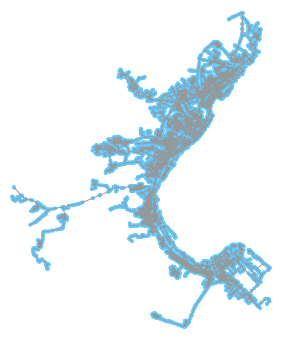

40657 45074


In [2]:
ox.utils.config(all_oneway=True)
G = ox.graph_from_place('Volgograd', network_type='drive', simplify = False)
G = ox.project_graph(G)
fig, ax = ox.plot_graph(G)
print(len(G.nodes),len(G.edges))

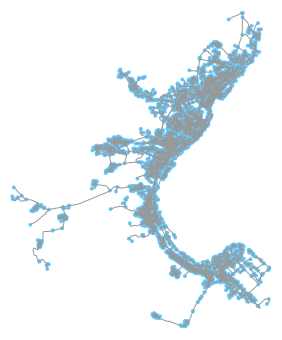

10197 14614


In [3]:
G_simp = ox.simplify.simplify_graph(G)
G_simp = ox.project_graph(G_simp)
fig, ax = ox.plot_graph(G_simp)
print(len(G_simp.nodes),len(G_simp.edges))

In [ ]:
#ox.save_load.save_as_osm(G,node_tags=['highway'], node_attrs=['id', 'lat', 'lon'], edge_tags=['highway', 'lanes', 'maxspeed', 'oneway'], edge_attrs=['id'], oneway=False, merge_edges=True, edge_tag_aggs=None, filename='graph.osm', folder=None)

In [64]:
#ox.utils.config(all_oneway=False)
G_ox = ox.core.graph_from_file('graph.osm',  simplify=False, retain_all=True)

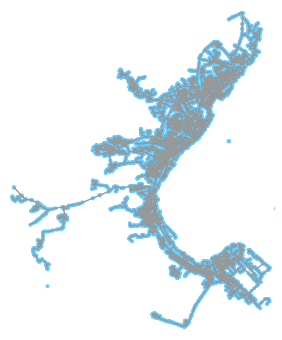

85090 40767


In [5]:
G_ox = ox.project_graph(G_ox)
fig, ax = ox.plot_graph(G_ox)
print(len(G_ox.edges),len(G_ox.nodes))

In [156]:
import csv
from lxml import etree as et
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
import networkx as nx
from random import choices, random

In [158]:
def readAdjMatrix(path_doc):
    with open(path_doc,'r') as f:
        G = nx.DiGraph()
        lines = f.readlines()
        nlist = lines[0][1:].split(',')
        G.add_nodes_from(nlist)
        lines = lines[1:]
        elist = []
        a = True
        l = len(nlist)
        a *= (l == len(lines))
        for i in range(len(lines)):
            _from, weights = lines[i].split(',')[0], list(map(int,lines[i].split(',')[1:]))
            a = (l == len(weights))
            for j in range(len(weights)):
                elist.append((_from,nlist[j],{'weight': weights[j]}))
        G.add_edges_from(elist)
        print(a)
        return G
        

In [66]:
f = open('100houses.txt', 'r')
houses_id = [house[:-1] for house in f.readlines()]
f.close()
f = open('10med.txt', 'r')
med_id = [med[:-1] for med in f.readlines()]
f.close()
print(len(houses_id),len(med_id))


100 10


In [67]:
nodes_id = [node for node in G_ox.nodes]
nodes_data = G_ox.nodes(data=True)

def distance(node1,node2):
    R = 6373.0
    lon1 = radians(nodes_data[int(node1)]['x'])#lon
    lat1 = radians(nodes_data[int(node1)]['y'])#lat
    lon2 = radians(nodes_data[int(node2)]['x'])
    lat2 = radians(nodes_data[int(node2)]['y'])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def nearest_node_id(node_a_id,nodes_id, pass_list = []):
    copy_id = nodes_id
    min_dist = float('inf')
    if pass_list.count(node_a_id) == 0:
        pass_list.append(node_a_id)
    for elem in pass_list:
        while copy_id.count(elem) > 0:
            copy_id.remove(elem)
    for node_b_id in copy_id:
        d = distance(node_a_id,node_b_id)
        if d < min_dist:
            min_dist = d
            nni = node_b_id
    return [nni, min_dist]

In [107]:
#G.add_node(a)
#G.add_edge(from, to, weight=w0)
#G.add_nodes_from(nlist)
#elist = [('a', 'b', 5.0), ('b', 'c', 3.0)]
#G.add_edges_from(elist)
#G.remove_node(a)
#G.remove_nodes_from(nlist)
#G.remove_edge(from, to)
#G.remove_edges_from(elist)
#G[from][to]['weight'] = w1


In [68]:
#Добавим сначала то, что есть в графе, потом дополним
osm_file = 'graph.osm'
G = nx.DiGraph()
context = et.iterparse(osm_file, events=('end',), tag='node')
nodes = []
for event, elem in context:
    nodes.append(elem.get('id'))
    elem.clear()
    while elem.getprevious() is not None:
        del elem.getparent()[0]
del context
G.add_nodes_from(nodes)
for h in houses_id:
    G.nodes[h]['building'] = 'house'
for m in med_id:
    G.nodes[m]['building'] = 'hospital'
print(G.number_of_nodes())

context = et.iterparse(osm_file,events=('end',),tag='way')
edges = []
for event, elem in context:
    oneway = 0
    #Определим свойства
    for child in elem.iterchildren('tag'):
        key = child.get('k')      
        #Возможно, дорога односторонняя
        if key == 'oneway' and child.get('v') == 'yes':
            oneway = 1
    #Узнаем, какие вершины состоят в пути
    nodes_list = []
    for child in elem.iterchildren('nd'):
        _id = child.get('ref')
        nodes_list.append(_id)
    #Добавляем ребра с весами в список смежности
    if oneway == 1:
        for i in range(len(nodes_list)-1):
            #Добавляем вершины
            from_node, to_node = nodes_list[i:i+2]
            if (from_node == '5283937166' and to_node == '5283937738') or (from_node == '5283937738' and to_node == '5283937166'):
                print('!!!')
            d = distance(from_node, to_node)
            edges.append((from_node, to_node, {'weight': d}))
    else:
        for i in range(len(nodes_list)-1):
            from_node, to_node = nodes_list[i:i+2]
            if (from_node == '5283937166' and to_node == '5283937738') or (from_node == '5283937738' and to_node == '5283937166'):
                print('!!!')
            d = distance(from_node, to_node)
            edges.append((from_node, to_node, {'weight': d}))
            edges.append((to_node, from_node, {'weight': d}))
    elem.clear()
    while elem.getprevious() is not None:
        del elem.getparent()[0]
del context

G.add_edges_from(edges)
print(G.number_of_edges())

nodes_id = [str(node) for node in G_ox.nodes]
nodes_data = G_ox.nodes(data=True)
#Добавим ребра к домам и больницам
nearest_nodes_id = []
houses = []
for h_id in houses_id:
    nni, min_dist = nearest_node_id(h_id,nodes_id,houses_id+med_id)
    w = 1 + random()
    nearest_nodes_id.append((nni, h_id, {'weight': min_dist*w}))
    nearest_nodes_id.append((h_id, nni, {'weight': min_dist*w}))
    houses.append(str(nni))
        
med = []
copy_id = nodes_id   
for m_id in med_id:
    nni, min_dist = nearest_node_id(m_id,nodes_id,houses_id+med_id)
    w = 1 + random()
    nearest_nodes_id.append((nni, m_id, {'weight': min_dist*w}))
    nearest_nodes_id.append((m_id, nni, {'weight': min_dist*w}))
    med.append(str(nni))
    
G.add_edges_from(nearest_nodes_id)
print(G.number_of_edges())

40767
85096
85316


In [69]:
#Создадим список смежности
nx.readwrite.adjlist.write_adjlist(G,'adj_list.csv')

In [70]:
#Список с весами
with open('adj_list2.csv','w',newline='') as csv_file:
    csv_file.write('from_id to_id,edge_weight\n')
    for _from in list(G.nodes):
        s = str(_from)
        for _to in G.successors(_from):
            s = s + ' ' + str(_to) + ',' + str(G[_from][_to]['weight'])
        csv_file.write(s + '\n')


In [35]:
#Создадим матрицу смежности
#nx.linalg.graphmatrix.adjacency_matrix(G)
adj_matrix = nx.to_pandas_adjacency(G)

In [ ]:
adj_matrix.to_csv('adj_matrix.csv')

In [ ]:
print(adj_matrix)

In [ ]:
matrix = adj_matrix.values
print(matrix)

In [71]:
class MinNodeHeap:

    def __init__(self,g={}):
        self.heap = []
        self.size = 0
        self.g = g

    def left_index(self,i):
        return 2*i+1

    def right_index(self,i):
        return 2*i+2

    def parent_index(self,i):
        return (i-1)//2

    def min_heapify(self,i):
        l = self.left_index(i)
        r = self.right_index(i)

        if l < self.size and self.g[self.heap[l]]['weight'] < self.g[self.heap[i]]['weight']:
            smallest = l
        else:
            smallest = i
        if r < self.size and self.g[self.heap[r]]['weight'] < self.g[self.heap[smallest]]['weight']:
            smallest = r
        if smallest != i:
            self.g[self.heap[i]]['index'], self.g[self.heap[smallest]]['index'] = self.g[self.heap[smallest]]['index'], self.g[self.heap[i]]['index']           
            self.heap[i], self.heap[smallest] = self.heap[smallest], self.heap[i]
            self.min_heapify(smallest)

    def build_min_heap(self,_NodeView):
        self.heap = [None for i in range(len(_NodeView))]
        for elem in self.g.keys():
            self.heap[self.g[elem]['index']] = elem
#         self.heap = list(_NodeView)
        self.size = len(_NodeView)
#         for i in range(len(_NodeView)//2,-1,-1):
#             self.min_heapify(i)
            
    def extract_min(self):
        if self.size < 1:
            return None
        _min = self.heap[0]
        self.g[self.heap[self.size-1]]['index'] = self.g[self.heap[0]]['index']
        self.heap[0] = self.heap[self.size-1]      
        self.size -= 1
        self.min_heapify(0)
        return _min
    
    def decrease_key(self,_id,key):
        i = self.g[_id]['index']
        if key > self.g[_id]['weight']:
            raise KeyError
        self.g[_id]['weight'] = key
        while (i > 0) and (self.g[self.heap[self.parent_index(i)]]['weight'] > self.g[self.heap[i]]['weight']):
            self.g[self.heap[self.parent_index(i)]]['index'], self.g[self.heap[i]]['index'] = self.g[self.heap[i]]['index'], self.g[self.heap[self.parent_index(i)]]['index']
            self.heap[self.parent_index(i)], self.heap[i] = self.heap[i], self.heap[self.parent_index(i)]
            i = self.parent_index(i)

def initialize_single_sourse(G,_from):
    g = {}
    nodes_list = list(G.nodes).copy()
    nodes_list.remove(_from)
    for v_id, i in zip(nodes_list,range(1,len(G.nodes))):
        g[v_id] = {'way': [], 'weight':float('inf'), 'index':i}
    g[_from] = {'way':[_from], 'weight':0, 'index':0}
    return g

def relax(G,min_heap,_from,_to):
    if min_heap.g[_to]['weight'] > min_heap.g[_from]['weight'] + G[_from][_to]['weight']:
        key = min_heap.g[_from]['weight'] + G[_from][_to]['weight']
        min_heap.decrease_key(_to,key)
        min_heap.g[_to]['way'] = (min_heap.g[_from]['way']).copy()
        min_heap.g[_to]['way'].append(_to)
        
def dijkstra(G,_from,to_list = list(G.nodes)):
    g = initialize_single_sourse(G,_from)
    finish = 0
    nodes = MinNodeHeap(g)
    nodes.build_min_heap(G.nodes)
    while nodes.size > 0 and finish < len(to_list):
        u = nodes.extract_min()
        if to_list.count(u) > 0:
            finish += 1
        for v in G.successors(u):
            relax(G,nodes,u,v)
    return g


In [73]:
with open('ways_from_houses.txt','w',newline='') as f:
    f.write('from_id,to_id,way_weight,way\n')
    for h_id in houses_id:
        a = dijkstra(G,h_id,med_id)
        for m_id in med_id:
            s = h_id + ',' + m_id + ',' + str(a[m_id]['weight'])
            if a[m_id]['way'] != '':
                way = ','.join(a[m_id]['way'])
                s = s + ',' + way
            f.write(s + '\n')

with open('ways_from_med.txt','w',newline='') as f:  
    f.write('from_id,to_id,way_weight,way\n')
    for m_id in med_id:        
        a = dijkstra(G,m_id,houses_id)
        for h_id in houses_id:                
            s = m_id + ',' + h_id + ',' + str(a[h_id]['weight'])
            if a[h_id]['way'] != '':
                way = ','.join(a[h_id]['way'])
                s = s + ',' + way
            f.write(s + '\n')


min_ways = {}         
with open('ways_from_med.txt','r') as f:
    lines = f.readlines()
    lines = lines[1:] 
    for line in lines:
        split_line = line.split(',')
        _from = split_line[0]
        _to = split_line[1]
        weight = float(split_line[2])                
        if weight != float('inf'):
            way = list(map(int,split_line[4:-1]))
        else:
            way = []           
        if min_ways.get(_from) == None:
            min_ways[_from] = {_to:{'weight':weight,'way':way}}
        else:
            min_ways[_from][_to] = {'weight':weight,'way':way}
            
with open('ways_from_houses.txt','r') as f:  
    lines = f.readlines()
    lines = lines[1:]
    for line in lines:
        split_line = line.split(',')
        _from = split_line[0]
        _to = split_line[1]
        weight = float(split_line[2])                
        if weight != float('inf'):
            way = list(map(int,split_line[4:-1]))
        else: 
            way = []           
        if min_ways.get(_from) == None:
            min_ways[_from] = {_to:{'weight':weight,'way':way}}
        else:
            min_ways[_from][_to] = {'weight':weight,'way':way}

In [74]:
#1.1.a
#Из домов в ближайшие больницы
min_way = {}
for _from in houses_id:
    for _to in med_id:      
        if min_way.get(_from) == None:
            min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'],'way':min_ways[_from][_to]['way']}
        elif min_way[_from]['weight'] > min_ways[_from][_to]['weight']:
            min_way[_from]['to'] = _to
            min_way[_from]['weight'] = min_ways[_from][_to]['weight']
            min_way[_from]['way'] =  min_ways[_from][_to]['way']

ways = []            
with open('shortest_ways_from_houses.txt','w',newline='') as f:  
    f.write('from_id,to_id,way_weight\n')
    s = ''
    for h_id in min_way.keys():
        s = s + h_id + ',' + min_way[h_id]['to'] + ',' + str(min_way[h_id]['weight'])+'\n'
        if min_way[h_id]['weight'] != float('inf'):
            ways.append(min_way[h_id]['way'])
    f.write(s)

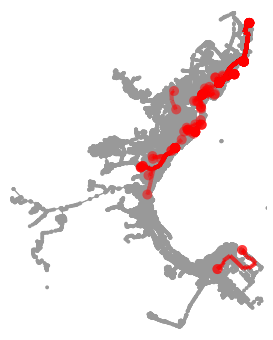

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a7f8834f0>)

In [75]:
ox.plot_graph_routes(G_ox, ways)

In [76]:
#Из больниц в ближайшие дома
min_way = {}
for _from in med_id:
    for _to in houses_id:      
        if min_way.get(_from) == None:
            min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'],'way':min_ways[_from][_to]['way']}
        elif min_way[_from]['weight'] > min_ways[_from][_to]['weight']:
            min_way[_from]['to'] = _to
            min_way[_from]['weight'] = min_ways[_from][_to]['weight']
            min_way[_from]['way'] =  min_ways[_from][_to]['way']

ways = []            
with open('shortest_ways_from_med.txt','w',newline='') as f:  
    f.write('from_id,to_id,way_weight\n')
    s = ''
    for h_id in min_way.keys():
        s = s + h_id + ',' + min_way[h_id]['to'] + ',' + str(min_way[h_id]['weight'])+'\n'
        if min_way[h_id]['weight'] != float('inf'):
            ways.append(min_way[h_id]['way'])
    f.write(s)

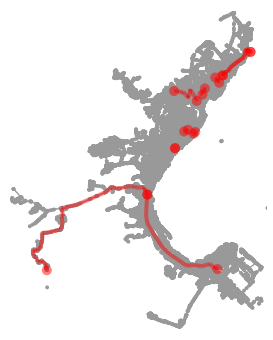

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a7fbe41f0>)

In [77]:
ox.plot_graph_routes(G_ox, ways)

In [78]:
#Туда-обратно, начиная с домов
min_way = {}
for _from in houses_id:
    for _to in med_id:      
        if min_way.get(_from) == None:
            min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight'],'way':min_ways[_from][_to]['way'],'way_back':min_ways[_to][_from]['way']}
        elif min_way[_from]['weight'] > min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']:
            min_way[_from]['to'] = _to
            min_way[_from]['weight'] = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
            min_way[_from]['way'] =  min_ways[_from][_to]['way']
            min_way[_from]['way_back'] = min_ways[_to][_from]['way']

ways = []            
with open('shortest_ways_from_houses_and_back.txt','w',newline='') as f:  
    f.write('from_id,to_id,way_weight\n')
    s = ''
    for h_id in min_way.keys():
        s = s + h_id + ',' + min_way[h_id]['to'] + ',' + str(min_way[h_id]['weight'])+'\n'
        if min_way[h_id]['weight'] != float('inf'):
            ways.append(min_way[h_id]['way'])
            ways.append(min_way[h_id]['way_back'])
    f.write(s)
    

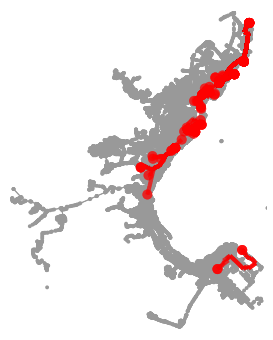

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a565fe2e0>)

In [79]:
ox.plot_graph_routes(G_ox, ways)

In [80]:
max_weight = 10 #км

In [81]:
#1.1.b
near_ways = []
with open('ways_from_houses.txt','r') as f:  
    next(f)
    for line in f:
        split_line = line.split(',')
        _from = split_line[0]
        _to = split_line[1]
        weight = float(split_line[2])
        if weight != float('inf'):
            way = list(map(int,split_line[4:-1]))
        else: 
            way = []  
        if weight < max_weight:
            near_ways.append([_from,_to,weight,way])

ways= []
with open('near_houses.txt','w',newline='') as f:  
    f.write('from_id,to_id,weight\n')
    s = ''
    for way in near_ways:
        s = s + way[0] + ',' + way[1] + ',' + str(way[2]) +'\n'
        if way[2] != float('inf'):
            ways.append(way[3])
    f.write(s)

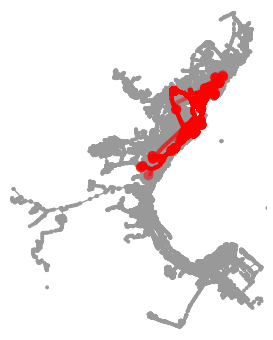

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a07be0af0>)

In [82]:
ox.plot_graph_routes(G_ox, ways)

In [83]:
near_ways = []
with open('ways_from_med.txt','r') as f:  
    next(f)
    for line in f:
        split_line = line.split(',')
        _from = split_line[0]
        _to = split_line[1]
        weight = float(split_line[2])
        if weight != float('inf'):
            way = list(map(int,split_line[4:-1]))
        else: 
            way = []  
        if weight < max_weight:
            near_ways.append([_from,_to,weight,way])

with open('near_med.txt','w',newline='') as f:  
    f.write('from_id,to_id,weight\n')
    s = ''
    for way in near_ways:
        s = s + way[0] + ',' + way[1] + ',' + str(way[2]) +'\n'
        if way[2] != float('inf'):
            ways.append(way[3])
    f.write(s)
      

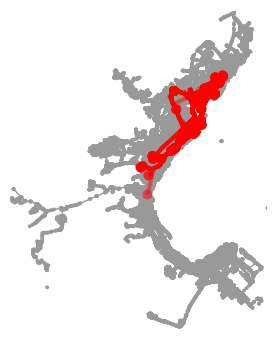

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a0964b9d0>)

In [84]:
ox.plot_graph_routes(G_ox, ways)

In [85]:
near_ways = []
for _from in houses_id:
    for _to in med_id:
        weight = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
        if weight < max_weight:
            near_ways.append([_from, _to, weight, min_ways[_from][_to]['way'], min_ways[_to][_from]['way']])
            

ways = []
with open('near_med.txt','w',newline='') as f:
    f.write('med_id, house_id,weight\n')
    s = ''
    for way in near_ways:
        s = s + way[0] + ',' + way[1] + ',' + str(way[2]) +'\n'
        ways.append(way[3])
        ways.append(way[4])
    f.write(s)
    

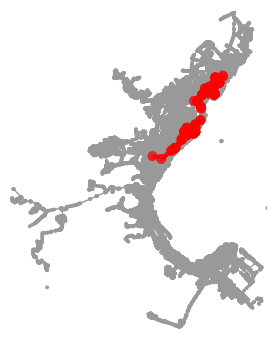

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a0b222be0>)

In [86]:
ox.plot_graph_routes(G_ox, ways)

In [87]:
#1.2
#Определить, какой из объектов расположен так, что время/расстояние между ним и
#самым дальним домом минимально (“туда”, “обратно”, “туда и обратно”)
minmax_way = {'weight':float('inf')}
for m_id in med_id:
    weight = 0
    for h_id in houses_id:
        if min_ways[m_id][h_id]['weight'] > weight and min_ways[m_id][h_id]['weight'] != float('inf'):
            _to = h_id
            weight = min_ways[m_id][h_id]['weight']
    if weight < minmax_way['weight']:
        minmax_way['weight'] = weight
        minmax_way['from'] = m_id
        minmax_way['to'] = _to
        minmax_way['way'] = min_ways[m_id][_to]['way']


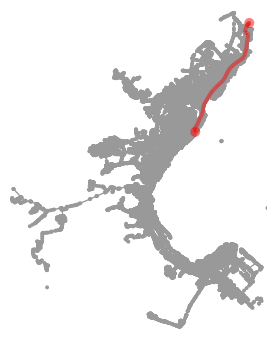

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a0653e490>)

In [88]:
ox.plot_graph_route(G_ox, minmax_way['way'])

In [89]:
minmax_way = {}
minmax_way['weight'] = float('inf')
for h_id in houses_id:
    weight = 0
    for m_id in med_id:
        if min_ways[h_id][m_id]['weight'] != float('inf') and min_ways[h_id][m_id]['weight'] > weight:
            _to = m_id
            weight = min_ways[h_id][m_id]['weight']
    if weight < minmax_way['weight']:
        minmax_way['weight'] = weight
        minmax_way['from'] = h_id
        minmax_way['to'] = _to
        minmax_way['way'] = min_ways[h_id][_to]['way']


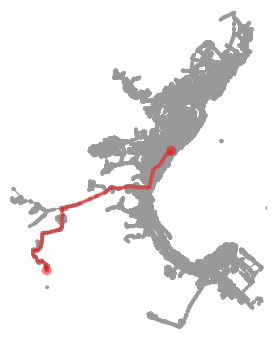

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a0e0a9df0>)

In [90]:
ox.plot_graph_route(G_ox, minmax_way['way'])

In [91]:
minmax_way = {'weight':float('inf')}

for m_id in med_id:
    weight = 0
    for h_id in houses_id:
        w0 = min_ways[m_id][h_id]['weight'] + min_ways[h_id][m_id]['weight']
        if w0 != float('inf') and w0 > weight:
            _to = h_id
            weight = w0
    if weight < minmax_way['weight']:
        min_way['weight'] = weight
        min_way['med'] = m_id
        min_way['house'] = _to


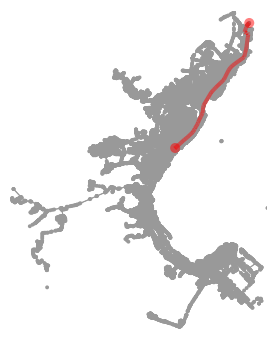

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a08f32640>)

In [92]:
ox.plot_graph_route(G_ox, min_ways[min_way['med']][min_way['house']]['way'])

In [93]:
#1.3
#Для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна
min_sum = float('inf')
for m_id in med_id:
    _sum = 0
    for h_id in houses_id:
        #Пока что есть пути с inf
        if min_ways[m_id][h_id]['weight'] != float('inf'):
            _sum += min_ways[m_id][h_id]['weight']
    if _sum < min_sum:
        min_sum = _sum
        _from = m_id

ways = []
for h_id in houses_id:
    if min_ways[_from][h_id]['weight'] != float('inf'):
        ways.append(min_ways[_from][h_id]['way'])
_from

'5882954099'

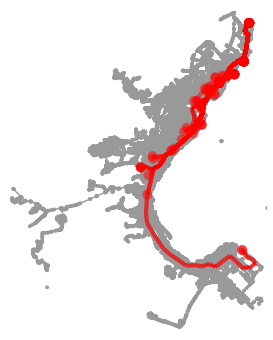

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a096af5e0>)

In [94]:
ox.plot_graph_routes(G_ox, ways)

In [95]:
#1.4
#Для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.
min_sum = float('inf')
for m_id in med_id:
    _sum = 0
    edges_set = set()
    for h_id in houses_id:
        #Пока что есть пути с inf
        if min_ways[m_id][h_id]['weight'] != float('inf'):
            edges_set.add(m_id + ' ' + h_id)
    for elem in list(edges_set):
        i,j = elem.split(' ')
        _sum += min_ways[i][j]['weight']
    if _sum < min_sum:
        min_sum = _sum
        _from = m_id

ways = []
for h_id in houses_id:
    if min_ways[_from][h_id]['weight'] != float('inf'):
        ways.append(min_ways[_from][h_id]['way'])
_from

'5882954099'

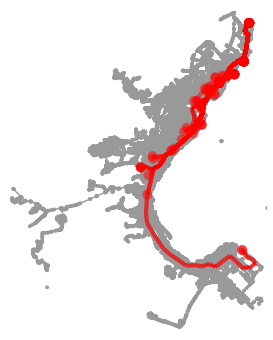

(<Figure size 521.146x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25a12812b20>)

In [96]:
ox.plot_graph_routes(G_ox, ways)